# Отчет по лабораторной работе №6. Задача Коши и решение систем ДУ.
## Выполнил Сарафанов Ф.Г., 430 группа/2018, 19 вариант


## Постановка задачи

Рассмотрим численное решение уравнения 

$$
y''+y'-4y=t\cdot e^{-t},\quad y(0)=1, y'(0)=0,\quad t\in[0,2]
$$

запишем его в виде системы ДУ 1-го порядка:

$$
\begin{cases}
y'=z\\
z'=-z+4y+t\cdot e^{-t}
\end{cases}%,\qquad i=2,3,\ldots, n
$$

В программе используется векторный подход: массив переменных <code>Y=[y z], y=Y[0], z=Y[1]</code>, и система имеет вид

$$
\begin{cases}
Y[0]'=Y[1]\\
Y[1]'=-Y[1]+4\cdot Y[0]+t\cdot e^{-t}
\end{cases}
$$

Здесь сопоставляется вектор производных и вектор правых частей

$$
Y'=f(t,Y),\; \text{где}\;f(t,Y)=
\begin{bmatrix}
Y[1]\\
-Y[1]+4\cdot Y[0]+t\cdot e^{-t}
\end{bmatrix}
$$

## Метод Тейлора 3-го порядка

Можно показать, что в векторном виде итерационный процесс решения методом Тейлора 3-го порядка будет записываться в виде

$$
Y^{n+1}=Y^n+hf+\frac{h^2}{2}\left(\frac{\partial f}{\partial t}+Jf\right)+\frac{h^3}{6}\left(\frac{\partial ^2f}{\partial t^2}+\frac{\partial J}{\partial t}f +J\frac{\partial f}{\partial t}\right)
$$

Где все функции (вектора, матрицы) берутся в точке $Y^n, t^n$.

Импорт библиотек

In [17]:
from sympy import Symbol,diff,exp,cos,sin,Matrix,var,symbols
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy import interpolate
from numpy.linalg import norm

Зададим условия расчетов:

In [2]:
n=2 # количество переменных
y00=np.array([1,0]) # начальные условия y(0)=1,y'(0)=0
Tn0,tmax0=0,2 # временной интервал
h=0.5 # начальный шаг
eps=0.03 # точность

Задаем символьные переменные для расчета всех необходимых величин:

In [3]:
t=Symbol('t')
y = sym.Matrix(n, 1, lambda i,j:var('y[%d]' % (i)))

Задаем правую часть уравнения

In [4]:
def f(T,y):
    return Matrix([\
                y[1],\
                -y[1]+4*y[0]+T*exp(-T),\
                ])

Чтобы не загружаться излишними символьными вычислениями, вычислим символьно все нужные функции и преобразуем в численный вид

In [5]:
A='def pfpt(t,y):\n\treturn np.array(%s)'%(str(np.array2string(np.array(f(t,y).diff(t)).T[0],separator=', ')).replace('Matrix(',''))+'\n'+\
    'def p2fpt2(t,y):\n\treturn np.array(%s)'%(str(np.array2string(np.array(f(t,y).diff(t).diff(t)).T[0],separator=', ')).replace('Matrix(',''))+'\n'+\
    'def J(t,y):\n\treturn np.array(%s)'%(str(f(t,y).jacobian(y)).replace('Matrix(',''))+'\n'+\
    'def model(t,y):\n\treturn np.array(%s)'%(str(np.array2string(np.array(f(t,y)).T[0],separator=', ')).replace('Matrix(',''))+'\n'+\
    'def pJpt(t,y):\n\treturn np.array(%s)'%(str(f(t,y).jacobian(y).diff(t)).replace('Matrix(',''))

exec(A.replace('))',')',100))

Зададим массив времени и массив координат решения:

In [6]:
Time=np.array([])
Y = np.empty((0,n),np.float32)

Итерационный процесс:

In [7]:
N=0
while True:
    h=h/2

    yn=y00
    Tn=Tn0
    tmax=tmax0  

    N+=1

    OldTime=Time
    OldY=Y

    Time=np.array([])
    Y = np.empty((0,n),np.float32)

    while Tn<=tmax:

        Tn=Tn+h
        yo=yn
        Time=np.append(Time,Tn)

        Y=np.append(Y,[yo],axis=0)

        const_pfpt=pfpt(Tn,yn)
        const_J=J(Tn,yn)
        const_F=model(Tn,yn)
        yn=np.array(yn+h*(const_F+h/2*(const_pfpt+np.dot(const_J,const_F))+h**2/6*(p2fpt2(Tn,yn)+\
            np.dot(pJpt(Tn,yn),const_F)+np.dot(const_J,const_pfpt))))
    print('итерация',N,len(Y))
    if N>=3:
        YY=Y
        YO=OldY
        if len(YY)%2!=0:
            YY=YY[:-1]
        if len(YO)%2!=0:
            YO=YO[:-1]
        YY=np.array(YY,dtype=np.float32)
        YO=np.array(YO,dtype=np.float32)
        delta=np.max(norm(YY[0::2]-YO,axis=0))
        print('погрешность',delta)
        if N>10*2:
            break
        if delta<eps:
            break

итерация 1 9
итерация 2 17
итерация 3 33
погрешность 0.21015728
итерация 4 65
погрешность 0.03470644
итерация 5 129
погрешность 0.044172414
итерация 6 257
погрешность 0.05174545
итерация 7 513
погрешность 0.044470314
итерация 8 1025
погрешность 0.034323636
итерация 9 2049
погрешность 0.025303021


Так же решим встроенным решателем:

In [8]:
solve = solve_ivp(model,[Tn0,tmax0],y00,method='LSODA',min_step=0.01,max_step=0.01)

Time2=solve.t
Z=solve.y

Z1,Z2=Z
Y1,Y2=Y.T

График решения

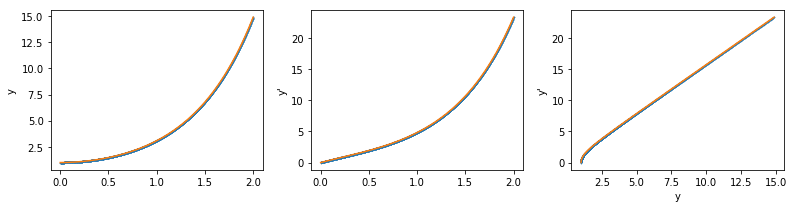

In [48]:
f, (ax1, ax2,ax3) = plt.subplots(1,3, gridspec_kw = {'width_ratios':[3, 3,3]})
f.set_size_inches(11,3)

ax1.plot(Time,Y1,'*', markersize=1)
ax1.plot(Time2,Z1)
ax1.set_ylabel("y")
ax3.set_xlabel("t")

ax2.plot(Time,Y2,'*', markersize=1)
ax2.plot(Time2,Z2)
ax2.set_ylabel("y'")
ax3.set_xlabel("t")

ax3.plot(Y1,Y2,'*', markersize=1)
ax3.plot(Z1,Z2)
ax3.set_xlabel("y")
ax3.set_ylabel("y'")

f.tight_layout()
plt.show()

Чтобы не возиться с вычитанием массивов разной длины, можно решения разными способами  простейшим способом интерполировать на нужном отрезке (соединяя точки) и построить разность интерполирующих функций на одном и том же разбиении:

In [12]:
x = np.linspace(np.min(Time), np.max(Time),1000)
f = interpolate.interp1d(Time, Y1,axis=0, fill_value="extrapolate")
Y1f=f(x)
f = interpolate.interp1d(Time2, Z1,axis=0, fill_value="extrapolate")
Z1f=f(x)

x = np.linspace(np.min(Time), np.max(Time),1000)
f = interpolate.interp1d(Time, Y2,axis=0, fill_value="extrapolate")
Y2f=f(x)
f = interpolate.interp1d(Time2, Z2,axis=0, fill_value="extrapolate")
Z2f=f(x)

Разностные графики:

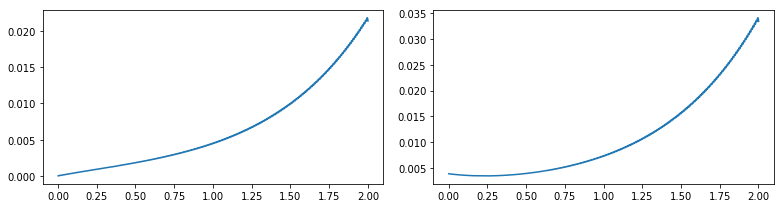

In [32]:
f, (plt1, plt2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1,1]})
f.set_size_inches(11,3)

plt1.plot(x,Z1f-Y1f)


plt2.plot(x,Z2f-Y2f)

f.tight_layout()
plt.show()